# TO DO:
Make pretty:
- Tune images so they look nice
- Add comments to functions
- Add docstrings to functions
- Add markdown sections, titles, etc.
- make outputs pretty
- make functions for repeating code
- ...

# What makes a quote viral ?

## Context

From the quotebank and the wikidata datasets, we will try to answer this question.

Before diving into this question, we will first explore the two datasets. From this, we will try to find the relevant features that can have an impact on the virality of the quote. With these features, a model will be build to try to predict the virality of a quote given the set of the found features.

We then split the data analysis in 2 phases:
1) Exploratory data analysis \
2) Classification

## The data

Quotebank dataset:

- `condition`: either `Sign Top` or `Sign Bottom`, depending on which form was sent.
- `id`: unique identifier for each insurance policy.
- `motorcycle_count`: number of motorcycles covered by the insurance policy.
- `baseline_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *previous (baseline)* contract. 
- `update_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *current (updated)* contract.

Wikidata dataset:

- `condition`: either `Sign Top` or `Sign Bottom`, depending on which form was sent.
- `id`: unique identifier for each insurance policy.
- `motorcycle_count`: number of motorcycles covered by the insurance policy.
- `baseline_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *previous (baseline)* contract. 
- `update_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *current (updated)* contract.

Some comments:

- Recall that a single policy can ensure up to 4 motorcycles, and thus, the suffixes [1-4] indicate that there are 4 
versions of these columns in the data (e.g., `baseline_motorcycle1`, `baseline_motorcycle2`, `baseline_motorcycle3`, 
`baseline_motorcycle4`). 

In [2]:
# Importing useful libraries/modules
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW

import utils
import feature_extraction

%load_ext autoreload
%autoreload 2

In [3]:
# Constants
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')

## Function for loading the data and extracting features in real time


In [4]:
@utils.cache_to_file_pickle("function-dataset_stats", cache_dir = CACHE_DIR)
def dataset_stats(data_dir, speaker_info_file_path):
    """
    Function for loading the Quotebank and speaker_attribute dataset, extract speakers informations and 
    generating dictionaries containing the frequency for each feature.
    
    Params:
        data_dir::[str]
            Path of the Data directory.
        speaker_info_file_path::[str]
            Path for the speaker_attributes.parquet file.
            
    Returns:
        num_quotes_count::[int]
            Total number of quotes.
        num_occurrences_counts::[dict]
            Dictionary with keys the number of quotes and values the number of occurencies.
        speakers_dict::[pd.DataFrame]
            DataFrame containing informations of each speaker: quote_count, age, num_occurrences, genderoccupation, 
            nationality, ethnic_group, religion.
    
    """
    
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = data_dir, 
                                                                            speaker_info_file_path = speaker_info_file_path)
    speaker_data = utils.get_filtered_speaker_info_data(data_dir, speaker_info_file_path, columns = ['id', 'date_of_birth',
                                                                                                     'gender', 'occupation', 
                                                                                                     'nationality', 
                                                                                                     'ethnic_group', 
                                                                                                     'religion'])
    
    # Initialization of dictionaries for extracting meaningfull features.
    num_quotes_count = 0
    num_occurrences_counts = {}
    speakers_dict = {}
    
    for line in utils.json_lines_generator(data_dir):        
        num_quotes_count += 1
        
        line_num_occurrences = line['numOccurrences']
        num_occurrences_counts[line_num_occurrences] = num_occurrences_counts.get(line_num_occurrences, 0) + 1
        
        # Solve ambiguities in speaker qids due to homonyms.
        speaker = feature_extraction.solve_ambiguous_speakers(line['qids'], linkcounts)
        
        # Calculate speaker age. In case of missing value the None value is added.
        speaker_birth_date = speaker_data.get(speaker, {}).get('date_of_birth', None)
        speaker_age = feature_extraction.get_speaker_age(speaker_birth_date, line['date'])
        
        # Add to the dict. the number of quotes, the age and the number of occurencies of the quotes for a speaker.
        # If there is a new speaker the dictionary is updated with the new informatins
        if speaker in speakers_dict:
            speakers_dict[speaker]['quote_count'] += 1
            speakers_dict[speaker]['age'].append(speaker_age)
            speakers_dict[speaker]['num_occurrences'] += line_num_occurrences
        else:
            speakers_dict[speaker] = {'quote_count': 1,
                                      'age': [speaker_age],
                                      'num_occurrences': line_num_occurrences}
            
        # Add to the dict. the qids for gender, occupation, nationality, ethnic group and religion for the different speaker.
        # In case of missing values, None is added to the dict.
            for info_key in ['gender', 'occupation', 'nationality', 'ethnic_group', 'religion']:
                speaker_value = speaker_data.get(speaker, {}).get(info_key, None)
                speaker_value_labels = []
                if speaker_value is not None:
                    for qid in speaker_value:
                        label = qid_labels.get(qid, None)
                        if label is not None:
                            speaker_value_labels.append(label)
                            
        # The qid are translated into their label.
                speaker_value_labels = speaker_value_labels if len(speaker_value_labels) != 0 else None
                speakers_dict[speaker][info_key] = speaker_value_labels
                
    # Since the dict. of speaker infos contains a list of age (in case of multiple quotes) we took the average of them.
    speakers_dict = pd.DataFrame(speakers_dict).T
    speakers_dict['age'] = speakers_dict['age'].apply(lambda l: None if all(elem is None for elem in l) else np.mean(l))
    
    return num_quotes_count, num_occurrences_counts, speakers_dict

# Load the Quotebank and speaker_attribute dataset, extract the relevant infos for each speaker and generate a dictionary 
# containing meaningfull features.
num_quotes_count, num_occurrences_counts, speakers_info = dataset_stats(data_dir = DATA_DIR, 
                                                                        speaker_info_file_path = SPEAKER_INFO_FILE_PATH)

# Data exploration: Quotebank

In [5]:
print(f"There are {num_quotes_count} quotes in this dataset")

There are 115584257 quotes in this dataset


In [6]:
speakers_info.head(10)

,quote_count,age,num_occurrences,gender,occupation,nationality,ethnic_group,religion
Q270316,4449,70.252416,23374,[Female],[Politician],[United States Of America],None,[Protestantism]
NaN,39988889,NaN,169373817,None,None,None,None,None
Q1253,13244,71.290094,101453,[Male],"[Politician, Diplomat]",[South Korea],[Koreans],"[Confucianism, Buddhism]"
Q468374,1076,60.941450,2905,[Male],[Guru],[India],None,[Hinduism]
Q19874690,212,56.750000,1562,[Male],[Physician],[Australia],None,[Sunni Islam]
Q18601741,14,NaN,16,[Male],[Musher],[United States Of America],None,None
Q5271548,594,78.186869,1622,[Female],"[Journalist, Historian, Blogger, Political Act...",[United States Of America],None,None
Q948687,6081,71.439566,16388,[Male],"[Television Presenter, Journalist, Writer]",[United States Of America],[Irish Americans],None
Q51797519,276,NaN,559,[Male],"[Sociologist, Criminologist]",None,None,None
Q2287947,17342,22.851055,140692,[Male],[Golfer],[United States Of America],None,None


In [7]:
print(f"For the {speakers_info.iloc[1]['quote_count']/num_quotes_count:.2%} of quotes we have no information about the speaker.")

For the 34.60% of quotes we have no information about the speaker.


### What is a Viral Quote?

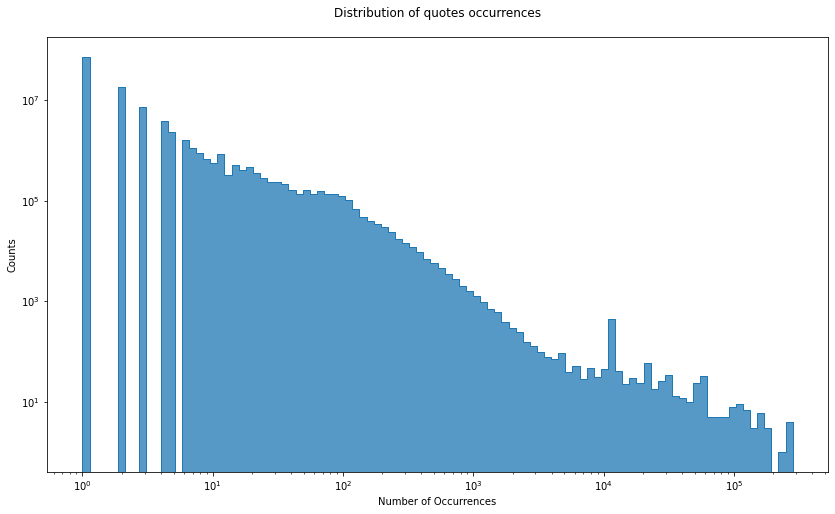

In [8]:
# Visualization of the distribution of number of occurences for each quote in the dataframe
plt.figure(figsize = (14, 8))
df_num_occurrences_counts = pd.DataFrame(num_occurrences_counts.items(), columns = ['Number of Occurrences', 'Count'])
sns.histplot(df_num_occurrences_counts, x = 'Number of Occurrences', weights = 'Count', bins = 100, log_scale = (True, True),element = "step");
plt.title("Distribution of quotes occurrences", pad=20)
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")
plt.show()

#### Check if it's a Power Law

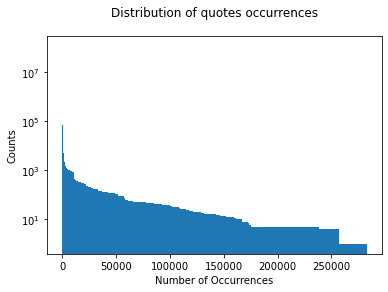

In [9]:
array_100 =plt.hist(df_num_occurrences_counts['Number of Occurrences'],weights=df_num_occurrences_counts['Count'],log=True, bins = 1000,cumulative=-1)
plt.title("Distribution of quotes occurrences", pad=20)
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")
plt.show()

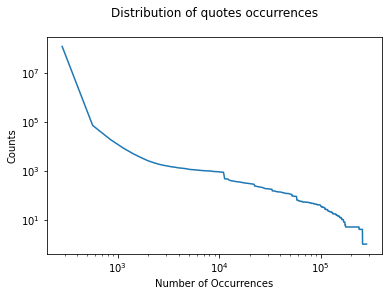

In [10]:
plt.loglog(array_100[1][1:],array_100[0])
plt.title("Distribution of quotes occurrences", pad=20)
plt.xlabel("Number of Occurrences")
plt.ylabel("Counts")
plt.show()

#### IT'S A POWER LAW (MAYBE: CHECK)!

In [11]:
def describe_weighted_stats(values, weights, percentiles = []):
    
    values, weights = list(values), list(weights)
    
    stats = DescrStatsW(values, weights = weights, ddof = 0)
    stats_dict = {'count': stats.sum_weights, 'mean': stats.mean, 'std': stats.std, 'min': stats.quantile(0.).item()}
    
    for percentile in sorted([0.25, 0.5, 0.75] + percentiles):
        stats_dict[f'{100*percentile}%'] = stats.quantile(percentile).item()
    
    stats_dict['max'] = stats.quantile(1.).item()
    
    return stats_dict

In [12]:
describe_weighted_stats(num_occurrences_counts.keys(), 
                        num_occurrences_counts.values(),
                        percentiles = [0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999])

{'count': 115584257.0,
 'mean': 3.9926449672121005,
 'std': 113.83433159703256,
 'min': 1,
 '25.0%': 1,
 '50.0%': 1,
 '75.0%': 2,
 '95.0%': 10,
 '96.0%': 13,
 '97.0%': 17,
 '98.0%': 26,
 '99.0%': 55,
 '99.5%': 90,
 '99.9%': 215,
 'max': 282552}

In [13]:
# define a viral quotes has a quotes that has at least 100 occurencies
viral_thr = 100

num_cited_more_thr = sum(value for key, value in num_occurrences_counts.items() if key >= viral_thr)
num_cited_less_thr = sum(value for key, value in num_occurrences_counts.items() if key < viral_thr)

print(f"{num_cited_less_thr/(num_cited_less_thr + num_cited_more_thr):.3%} of quotes are quoted less than {viral_thr} times")
print(f"Quotes cited {viral_thr} times or more:", num_cited_more_thr)
print(f"Quotes cited less than {viral_thr} times:", num_cited_less_thr)

99.587% of quotes are quoted less than 100 times
Quotes cited 100 times or more: 477879
Quotes cited less than 100 times: 115106378


## Extraction and Visualization of the Speakers' Features

In [14]:
def plot_weighted_distribution(df, feature, n_bars = 10, figsize = (15, 4), **plot_kwargs): 
    """ Function for plotting the distribution of the speaker features with no weigths,  with weigths corresponding to the quote counts and with the weigths corresponding to the number of occurences of the quotes.
    
    Params:
        df::[DataFrame]
          DataFrame containing informations of each speaker.  
        feature::[str]
            Name of the feature that is plotted.
        n_bars::[int]
            Number 
    
    """
    
    feature_titled = feature.replace('_', ' ').title()
    
    df = df[[feature, 'quote_count', 'num_occurrences']].rename(columns = {feature: feature_titled, 'quote_count': 'Quote Counts', 'num_occurrences': 'Number of Occurrences'})
    df.dropna(axis = 0, how = 'any', inplace = True)
    df.reset_index(drop = True, inplace = True)
        
    fig, axes = plt.subplots(1, 3, figsize = figsize)
    
    if feature_titled == 'Age':
        
        for ax, weight_col in zip(axes, (None, 'Quote Counts', 'Number of Occurrences')):
            sns.histplot(data = df, x = feature_titled, weights = weight_col, ax = ax, **plot_kwargs)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)                
    else:
        value_counts = {}
        for _, row in df.iterrows():
            for value in row[feature_titled]:
                if value not in value_counts:
                    value_counts[value] = {'Not Weighted': 0, 'Quote Counts': 0, 'Number of Occurrences': 0}

                value_counts[value]['Not Weighted'] += 1
                value_counts[value]['Quote Counts'] += row['Quote Counts']
                value_counts[value]['Number of Occurrences'] += row['Number of Occurrences']
                
        for ax, weight_col in zip(axes, ('Not Weighted', 'Quote Counts', 'Number of Occurrences')):
            top_n_most_common = sorted(value_counts, key = lambda key: value_counts[key][weight_col], reverse = True)[:n_bars]
            
            sns.barplot(x = top_n_most_common, y = [value_counts[key][weight_col] for key in top_n_most_common], ax = ax, **plot_kwargs)
            ax.set_ylabel('Counts')
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)
        
    fig.suptitle(feature_titled + " Distribution")
    fig.tight_layout()

### Age

In [15]:
def plot_weighted_distribution(df, feature, n_bars = 10, figsize = (15, 4), **plot_kwargs):    
    feature_titled = feature.replace('_', ' ').title()
    
    df = df[[feature, 'quote_count', 'num_occurrences']].rename(columns = {feature: feature_titled, 'quote_count': 'Quote Counts', 'num_occurrences': 'Number of Occurrences'})
    df.dropna(axis = 0, how = 'any', inplace = True)
    df.reset_index(drop = True, inplace = True)
        
    fig, axes = plt.subplots(1, 3, figsize = figsize)
    
    if feature_titled == 'Age':
        
        for ax, weight_col in zip(axes, (None, 'Quote Counts', 'Number of Occurrences')):
            sns.histplot(data = df, x = feature_titled, weights = weight_col, ax = ax, **plot_kwargs)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)                
    else:
        value_counts = {}
        for _, row in df.iterrows():
            for value in row[feature_titled]:
                if value not in value_counts:
                    value_counts[value] = {'Not Weighted': 0, 'Quote Counts': 0, 'Number of Occurrences': 0}

                value_counts[value]['Not Weighted'] += 1
                value_counts[value]['Quote Counts'] += row['Quote Counts']
                value_counts[value]['Number of Occurrences'] += row['Number of Occurrences']
                
        for ax, weight_col in zip(axes, ('Not Weighted', 'Quote Counts', 'Number of Occurrences')):
            top_n_most_common = sorted(value_counts, key = lambda key: value_counts[key][weight_col], reverse = True)[:n_bars]
            
            sns.barplot(x = top_n_most_common, y = [value_counts[key][weight_col] for key in top_n_most_common], ax = ax, **plot_kwargs)
            ax.set_ylabel('Counts')
            ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
            ax.set_title("Not Weighted" if weight_col is None else "Weighted by " + weight_col)
        
    fig.suptitle(feature_titled + " Distribution")
    fig.tight_layout()

In [16]:
speakers_info['age'].describe()

count    543213.000000
mean         54.340948
std          50.028787
min          -4.909091
25%          36.000000
50%          52.000000
75%          67.000000
max        9168.277778
Name: age, dtype: float64

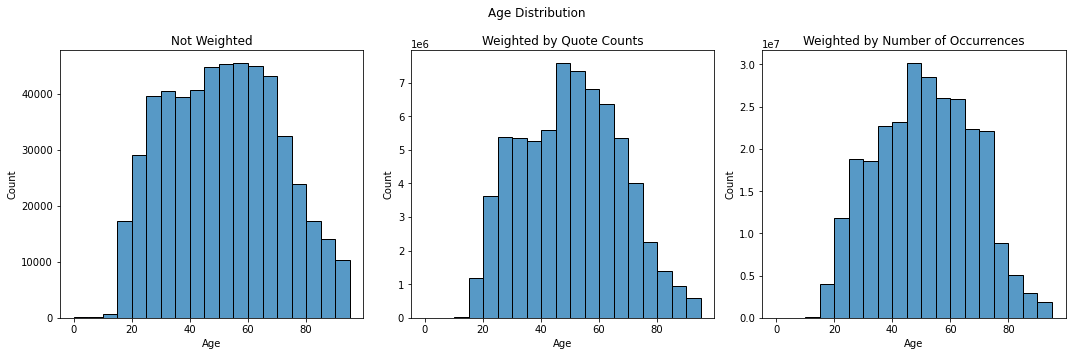

In [17]:
plot_weighted_distribution(speakers_info, 'age', bins = range(0, 100, 5), figsize = (15, 5))

In [18]:
# We remove all speaker that we don't know the age
speakers_info['age'].isna().sum()/speakers_info['quote_count'].sum()
ages = speakers_info[['age', 'quote_count']].dropna()
print(f"{(speakers_info['age'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which age couldn't be determined")
print(f"{((ages['age'] < 5) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker with an age smaller than 5")
print(f"{((ages['age'] > 95) * ages['quote_count']).sum() / ages['quote_count'].sum():.5%} quotes have speaker an age bigger than 95")


39.59676% quotes have speaker for which age couldn't be determined
0.00724% quotes have speaker with an age smaller than 5
1.05245% quotes have speaker an age bigger than 95


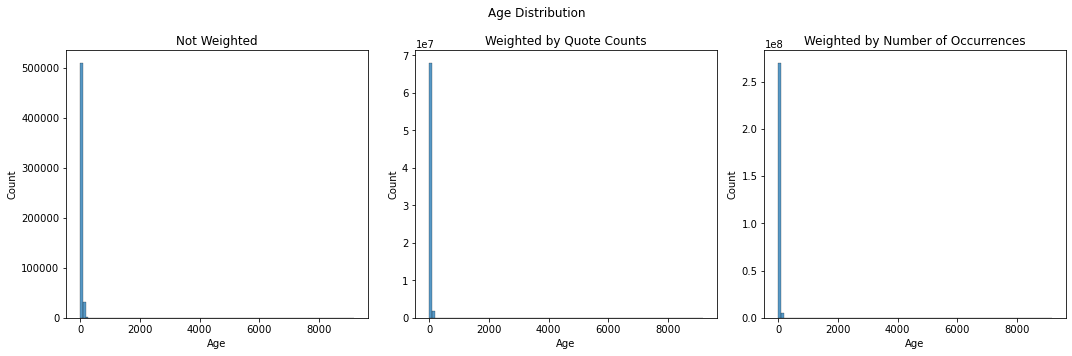

In [19]:
# Plot the Age distribution with no weigths, with weigths corresponding to the quote counts and with the weigths corresponding to the number of occurences of the quotes
plot_weighted_distribution(speakers_info, 'age', bins = 100, figsize = (15, 5))

By plotting the distribution of the frequency of quotes for different ages we can observe that there are some outliers. From the visualization of the statistics we notice that there are some ages that are negatives. This might be to some error in the dataset where the year of the quotation is before the birthdate of the speaker. Since, we are interested in extracting features that are related to the virality of a quotes we discard speaker ages of dead people and babys. We will focus only on quotes of people with age between 5 and 95.

### Gender

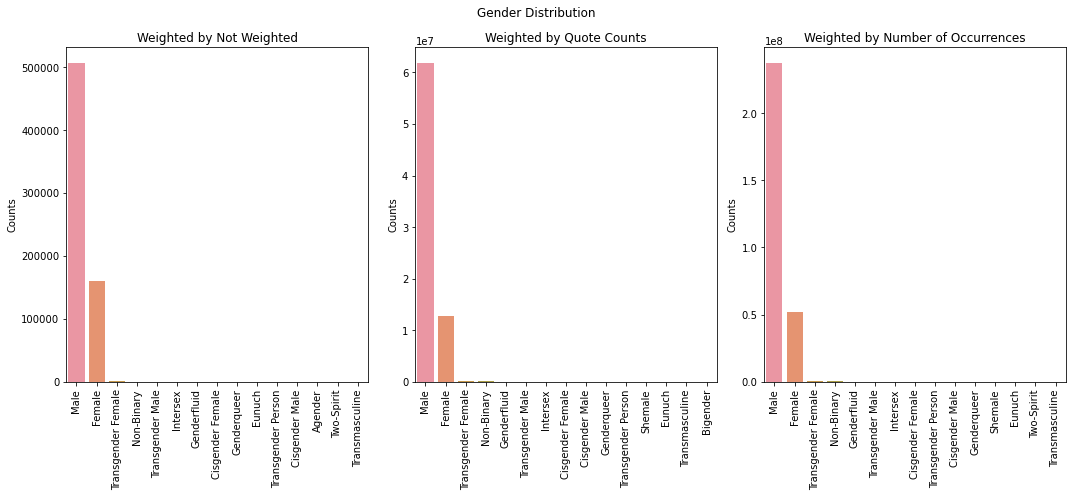

In [20]:
plot_weighted_distribution(speakers_info, 'gender', n_bars = 15, figsize = (15, 7))

In [21]:
print(f"{(speakers_info['gender'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which gender couldn't be determined")

35.38079% quotes have speaker for which gender couldn't be determined


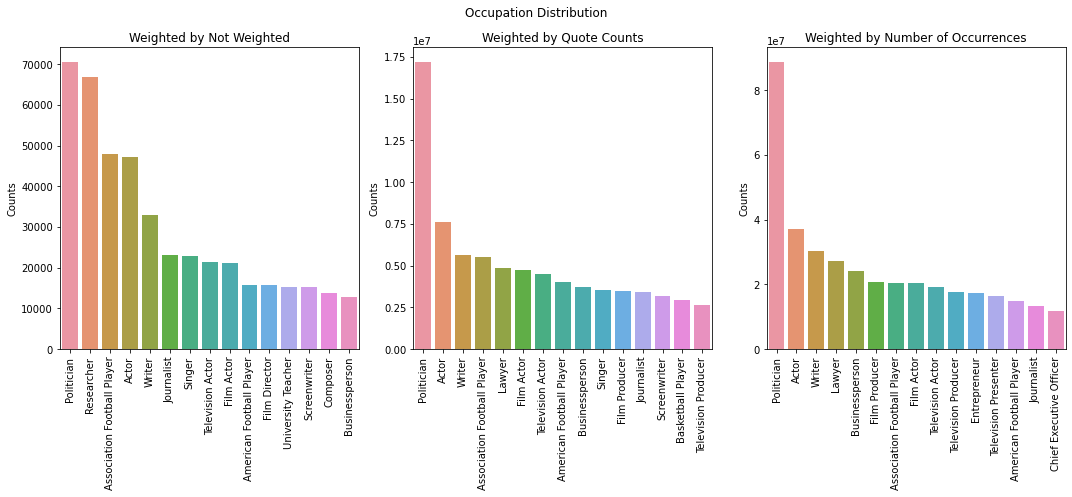

In [22]:
plot_weighted_distribution(speakers_info, 'occupation', n_bars = 15, figsize = (15, 7))

In [23]:
print(f"{(speakers_info['occupation'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which occupation couldn't be determined")

36.31932% quotes have speaker for which occupation couldn't be determined


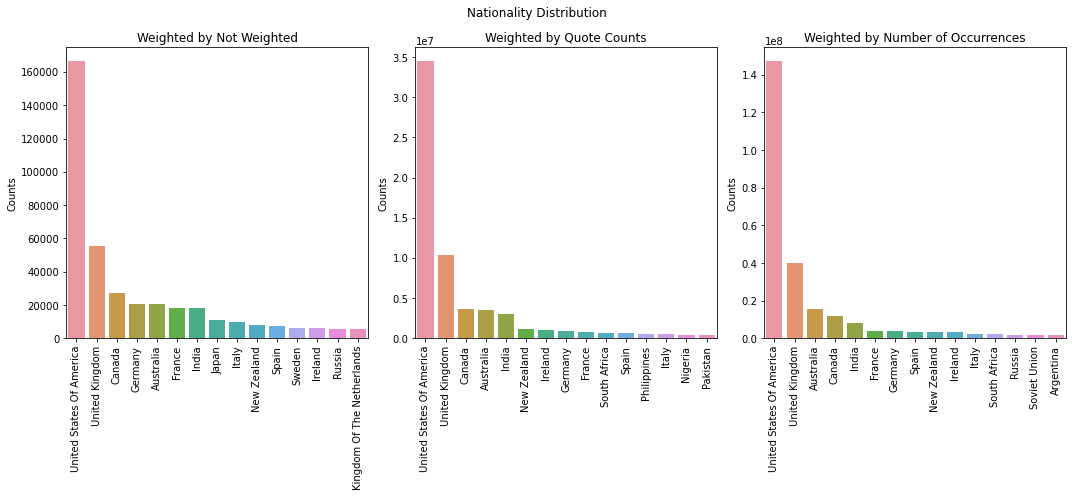

In [24]:
plot_weighted_distribution(speakers_info, 'nationality', n_bars = 15, figsize = (15, 7))

In [25]:
print(f"{(speakers_info['nationality'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which nationality couldn't be determined")

41.66662% quotes have speaker for which nationality couldn't be determined


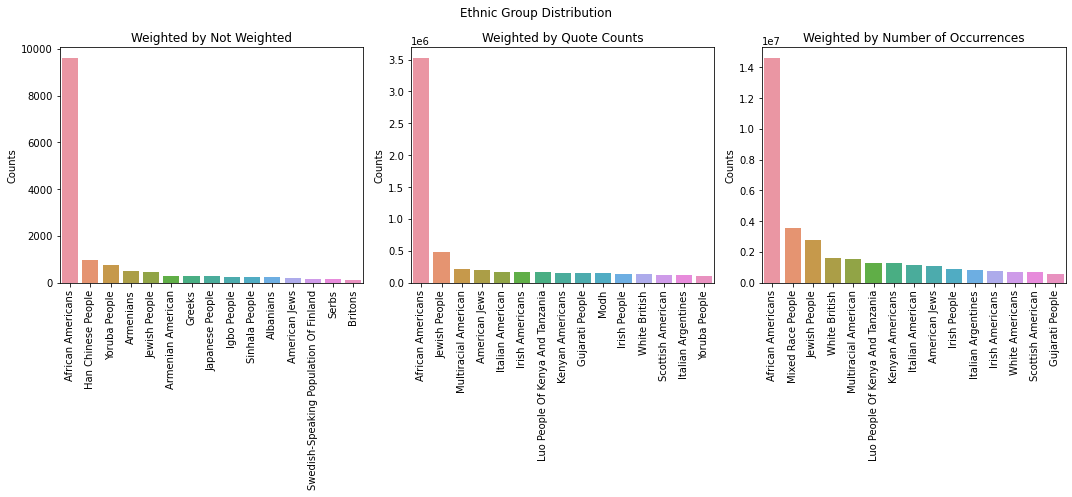

In [26]:
plot_weighted_distribution(speakers_info, 'ethnic_group', n_bars = 15, figsize = (15, 7))

In [27]:
print(f"{(speakers_info['ethnic_group'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which ethnic_group couldn't be determined")

93.97344% quotes have speaker for which ethnic_group couldn't be determined


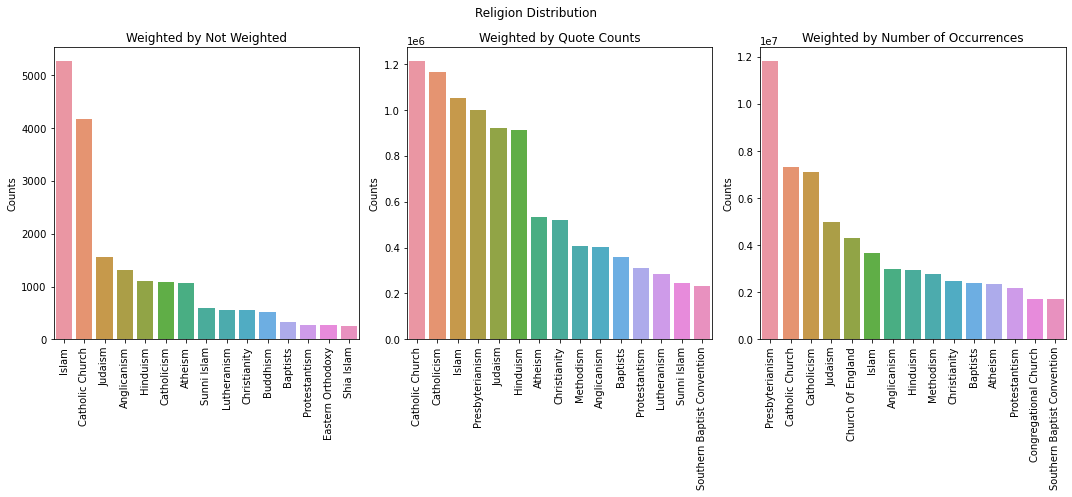

In [28]:
plot_weighted_distribution(speakers_info, 'religion', n_bars = 15, figsize = (15, 7))

In [29]:
print(f"{(speakers_info['religion'].isna() * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker for which religion couldn't be determined")

90.28355% quotes have speaker for which religion couldn't be determined


In [30]:
features_we_are_going_to_use = ['age', 'gender', 'occupation']

print(f"{(speakers_info[features_we_are_going_to_use].isna().any(axis = 1) * speakers_info['quote_count']).sum() / speakers_info['quote_count'].sum():.5%} quotes have speaker information missing")

40.41783% quotes have speaker information missing


## Heatmaps

In [158]:
from matplotlib.colors import LogNorm
def plot_quote_count_heatmaps(data,feature1,feature2):
    
    matrix_counts={}
    df = data[[feature1, feature2]].dropna(axis = 0, how = 'any')
    for _, row in df.iterrows():
        for value1 in row[feature1]:            
            if value1 not in matrix_counts:
                matrix_counts[value1] = {}
            for value2 in row[feature2]:
                if value2 not in matrix_counts[value1]:
                    matrix_counts[value1][value2]=0
                matrix_counts[value1][value2] += row['quote_count']
    df=pd.DataFrame(matrix_counts)
    plt.figure(figsize = (14, 8))
    sns.heatmap(df,norm=LogNorm())
    plt.title("Heatmap of Quote Counts between "+ feature1 + " and "+ feature2, pad=20)
    plt.xlabel(feature1.title())
    plt.ylabel(feature2.title())
    plt.show()

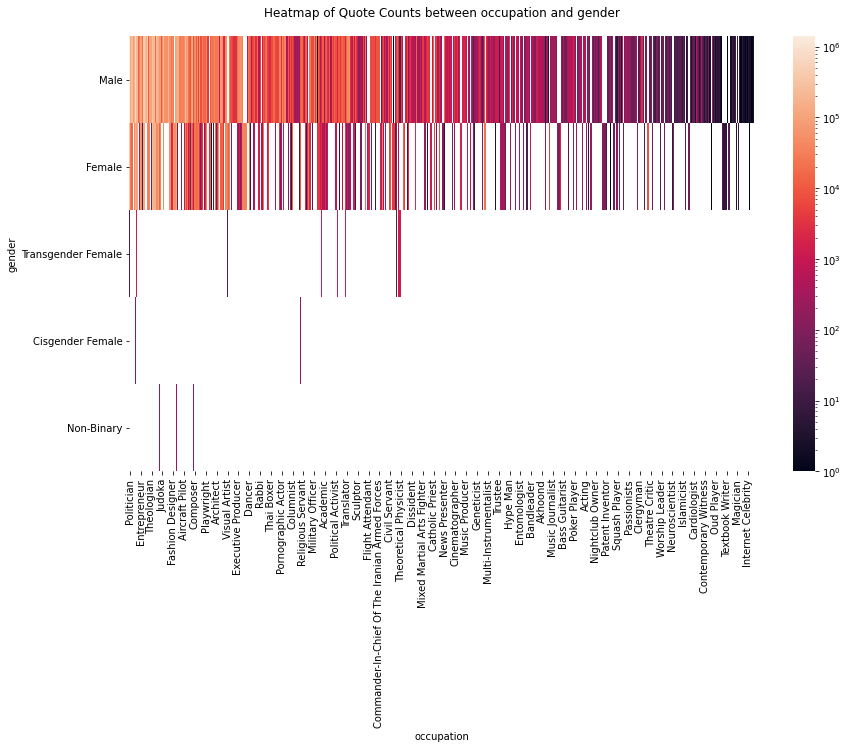

In [159]:
plot_quote_count_heatmaps(speakers_info,'occupation','gender')

<AxesSubplot:>

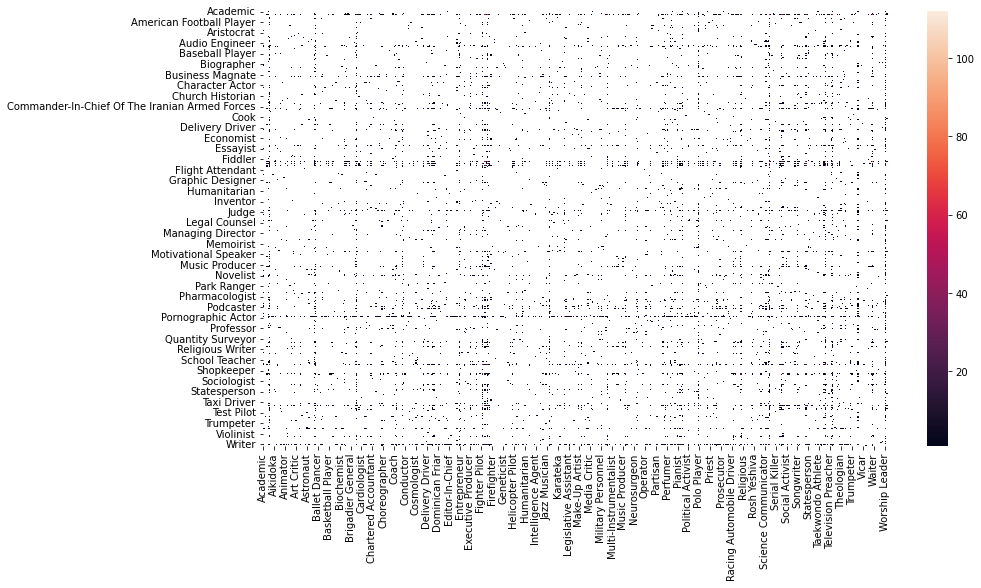

In [7]:
import itertools
from collections import Counter
df=speakers_info.dropna(axis = 0, how = 'any')
a=Counter()
for _, row in df.iterrows():
    a.update(Counter(list(itertools.combinations(row['occupation'], 2))))
        
ser = pd.Series(list(a.values()),
                  index=pd.MultiIndex.from_tuples(a.keys()))
df = ser.unstack()
plt.figure(figsize = (14, 8))
sns.heatmap(df)

## Extraction and Visualization of the Quote Topics

https://github.com/MaartenGr/BERTopic

No training: https://github.com/MaartenGr/KeyBERT or https://github.com/LIAAD/yake

In [ ]:
from random import randrange

from bertopic import BERTopic

In [ ]:
PREPROCESSED_DATASET_FILE_PATH = os.path.join(CACHE_DIR, "preprocessed_dataset.json.bz2")
BERT_MODEL_SAVE_PATH = os.path.join(CACHE_DIR, 'bert_model')

In [ ]:
def preprocess_dataset(data_dir, output_file_path, speaker_info_file_path,
                       can_reuse_output = True):
    if os.path.isfile(output_file_path) and can_reuse_output:
        return
    
    qid_labels, linkcounts = utils.query_wikidata_for_linkcounts_and_labels(data_dir = DATA_DIR, speaker_info_file_path = SPEAKER_INFO_FILE_PATH)
    
    # Load part of data extracted from Wikidata dump about speakers.
    speaker_data = utils.get_filtered_speaker_info_data(data_dir, speaker_info_file_path, columns = ['id', 'date_of_birth', 'gender', 'occupation'])
    
    with bz2.open(output_file_path, "wb") as output_file:
        
        for line in utils.json_lines_generator(data_dir):
                
            # Preprocess line features from line.
            preprocessed_line = feature_extraction.preprocess_line(line, speaker_data, qid_labels, linkcounts)
            
            # Ignore lines for which feature extraction failed due to unavailability of information or
            # due to filtering of extreme values.
            if preprocessed_line is None:
                continue
            
            # Store features of line.
            output_file.write((json.dumps(features) + '\n').encode('utf-8'))

In [ ]:
preprocess_dataset(DATA_DIR,
                   PREPROCESSED_DATASET_FILE_PATH,
                   SPEAKER_INFO_FILE_PATH,
                   can_reuse_output = True)

In [ ]:
def get_trained_bert_model(preprocessed_dataset_file_path, downsampling_factor = 100, calculate_probabilities = False, min_topic_size = 50, nr_topics = "auto"):
    
    # Training on all the quotes in the whole dataset is unfeasible on a 16 GB of RAM machine.
    # Hence we do two things to decrease the number of quotes used for training:
    # we only keep relevant quotes by selecting those corresponding to speakers we are interested in,
    # as explained in feature_extraction.extract_speaker_features, and we randomly sample a subset
    # of the data. The first thing was already done when generating preprocessed_dataset_file_path.
    quotes_subset = []
    for line in utils.json_lines_generator(preprocessed_dataset_file_path):
        if not randrange(0, downsampling_factor):
            quotes_subset.append(line['quotation'])
        
    print("Training on", len(quotes_subset), "quotes")
        
        
    # Min topics size should be fine-tuned: we have very large dataset hence a value of ~1000 is better than default one.
    # Also, may want to play with nr_topics: either leave it to default none, or auto, or set a manual value large enough
    # that topics do not get mixed up while merging. Also note it is heavy to run anything other than None.
    # In background, BERTopic uses UMAP, HDBSCAN, CountVectorizer. Each has their set of parameters, of which only a
    # subset is tunable via the BERTopic constructor. For best tuning, may want to look into them.
    bert_model = BERTopic(embedding_model = "all-MiniLM-L6-v2", 
                          calculate_probabilities = calculate_probabilities,
                          min_topic_size = min_topic_size, 
                          nr_topics = nr_topics,
                          verbose = True)
        
    bert_model.fit(quotes_subset)
    return bert_model

In [ ]:
bert_model = get_trained_bert_model(DATA_DIR, SPEAKER_INFO_FILE_PATH, 100)

In [ ]:
bert_model.save(BERT_MODEL_SAVE_PATH)

In [ ]:
bert_model.get_topic_info().head(20)

In [ ]:
for topic in range(20):
    print(f"Topic {topic}:")
    print('\n'.join(str(elem) for elem in bert_model.get_topic(topic)), '\n\n')

In [ ]:
bert_model.visualize_topics()

In [ ]:
bert_model.visualize_hierarchy(top_n_topics=60, height=1000)

In [ ]:
bert_model.visualize_barchart(top_n_topics=10, height=1000)

In [ ]:
bert_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
# This declining going to right is sign that first words in each topic are very representative of whole topic
bert_model.visualize_term_rank()

## Generating Training Samples and Labels
Once the pretreated dataset is obtained and BERT model trained, we can just parse the preprocessed dataset again converting each line into a feature vector and a label (viral / not viral).